In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model

2025-10-13 20:42:34.461577: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-13 20:42:34.473747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760368354.489817  170147 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760368354.494151  170147 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-13 20:42:34.509385: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Shape: (1, 200, 400, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
Test_Preds Shape (1, 200, 400)
(1, 200, 400)
(1080, 1920)
[0 1 2]


Text(0.5, 1.0, 'Test image with manual segmentation')

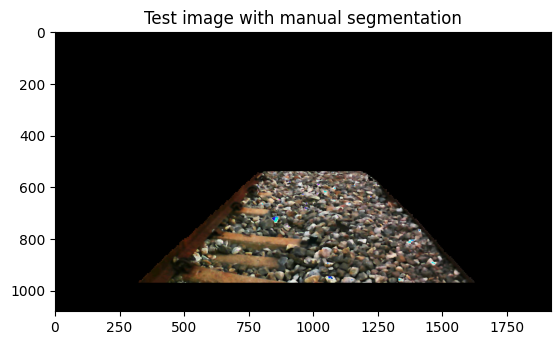

In [37]:
path = './../../../../../mnt/DATA/sda1/Suraj/Kunal/1_AUG_2025/Middle_BLACK_SPOT/image_003705.png'
img = Image.open(path)
model=load_model("/mnt/DATA/sda1/Suraj/Kunal/segmentation/Model_checkpoints/RailwayMiddleVideoSegmentation_1.h5")


img_resize = img.convert('L').resize((400,200))
img_np = np.array(img_resize, dtype = np.uint8)
img_np = (img_np-np.min(img_np))/(np.max(img_np)-np.min(img_np)) 
img_np = np.expand_dims(img_np, axis = 0)
img_np = np.expand_dims(img_np, axis = 3)

print("Shape:",np.shape(img_np))

test_preds = model.predict(img_np) #obtain predictions for glaucoma
test_preds = np.argmax(test_preds, axis = 3)


print("Test_Preds Shape",np.shape(test_preds))

test_preds = np.array(test_preds, dtype = np.uint8)
print(np.shape(test_preds))
test_preds_img = Image.fromarray(test_preds[0]).resize((1920,1080))

print(np.shape(test_preds_img))
print(np.unique(test_preds_img))


test_preds_img_modified = np.copy(test_preds_img)
np.array(test_preds_img_modified)
#test_preds_img_modified[test_preds_img_modified==1] = 10

test_preds_img_modified[test_preds_img_modified==0] = 0
test_preds_img_modified[test_preds_img_modified==2] = 2
test_preds_img_modified[test_preds_img_modified==1] = 0


# Blend the image and the mask
img = np.array(img,  dtype = np.uint8)
mask = np.stack((test_preds_img_modified,test_preds_img_modified,test_preds_img_modified), axis = 2)


overlay = np.array(img * mask, dtype = np.uint8)

overlay_img = Image.fromarray(overlay)

name = path.split('/')[-1].split('.')[0] + '.png'
overlay_img_path=overlay_img.save('./../../../../../mnt/DATA/sda1/Suraj/Kunal/Bird Eye View/Bird_Eye_view_test/'+name)



plt.imshow(overlay)
plt.title("Test image with manual segmentation")

In [4]:
data = np.load('/mnt/DATA/sda1/Suraj/Kunal/Bird Eye View/calibration_data.npz')
camera_matrix = data['camera_matrix']
dist_coeffs = data['dist_coeffs']
print("Camera Matrx:")
print(camera_matrix)
print("Dsit Coeffs:")
print(dist_coeffs)

Camera Matrx:
[[2.92683021e+03 0.00000000e+00 8.99141331e+02]
 [0.00000000e+00 2.92311744e+03 6.88066392e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Dsit Coeffs:
[[-0.51803214  0.1386817   0.02974808 -0.00292441  0.11194963]]


In [6]:
img = cv2.imread('/mnt/DATA/sda1/Suraj/Kunal/Bird Eye View/Bird_Eye_view_test/image001133/image_001133.png')
h, w = img.shape[:2]
new_camera_mtx, _ = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 1, (w, h))
undistorted = cv2.undistort(img, camera_matrix, dist_coeffs, None, new_camera_mtx)

In [7]:
blur = cv2.GaussianBlur(undistorted, (5, 5), 0)
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)

In [8]:
_, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

In [9]:
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if not contours:
    raise ValueError("No contour found.")
largest = max(contours, key=cv2.contourArea)

In [10]:
epsilon = 0.02 * cv2.arcLength(largest, True)
approx = cv2.approxPolyDP(largest, epsilon, True)

if len(approx) != 4:
    rect = cv2.minAreaRect(largest)
    box = cv2.boxPoints(rect)
    approx = np.int32(box)

In [11]:
def order_points(pts):
    pts = np.array(pts)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)
    return np.array([
        pts[np.argmin(s)],    # top-left
        pts[np.argmin(diff)], # top-right
        pts[np.argmax(s)],    # bottom-right
        pts[np.argmax(diff)]  # bottom-left
    ], dtype="float32")

src_points = order_points(approx.reshape(-1, 2))

In [12]:
img_vis = undistorted.copy()
cv2.drawContours(img_vis, [approx], -1, (0, 255, 0), 2)
for (x, y) in src_points.astype(int):
    cv2.circle(img_vis, (x, y), 6, (0, 0, 255), -1)



True

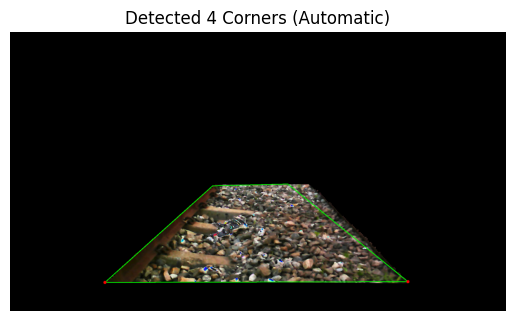

In [13]:
plt.title("Detected 4 Corners (Automatic)")
plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.axis('off')
cv2.imwrite('/mnt/DATA/sda1/Suraj/Kunal/Bird Eye View/Bird_Eye_view_test/Detected_corner.jpg',img_vis)

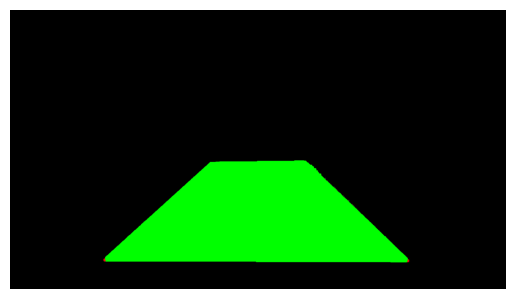

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
image = cv2.imread('/mnt/DATA/sda1/Suraj/Kunal/Bird Eye View/Bird_Eye_view_test/Detected_corner.jpg')
output = image.copy()

# Convert to HSV and create mask for green edges
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower_green = np.array([35, 40, 40])
upper_green = np.array([85, 255, 255])
mask = cv2.inRange(hsv, lower_green, upper_green)

# Clean up edges
kernel = np.ones((5, 5), np.uint8)
mask = cv2.dilate(mask, kernel, iterations=2)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Find contours and pick the largest one
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours:
    largest = max(contours, key=cv2.contourArea)

    # Fill the entire contour area with green
    cv2.drawContours(output, [largest], -1, (0, 255, 0), thickness=cv2.FILLED)
else:
    print("⚠️ No contour found.")

# Convert to RGB for plotting
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.imshow(output_rgb)
cv2.imwrite('/mnt/DATA/sda1/Suraj/Kunal/Bird Eye View/Bird_Eye_view_test/Green_patch.jpg',output_rgb)
plt.axis('off')
plt.show()

Corner Points: [(np.int32(1540), np.int32(960)), (np.int32(1138), np.int32(581)), (np.int32(774), np.int32(587)), (np.int32(367), np.int32(956))]


True

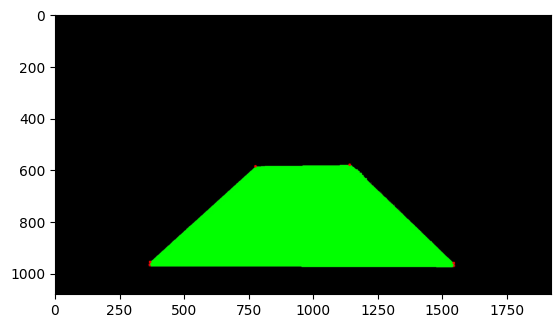

In [48]:
import cv2
import numpy as np

# Load image
image = cv2.imread('/mnt/DATA/sda1/Suraj/Kunal/Bird Eye View/Bird_Eye_view_test/Green_patch.jpg')
if image is None:
    raise ValueError("Image not found or path is incorrect.")

# Apply Gaussian blur
blurred = cv2.GaussianBlur(image, (5, 5), sigmaX=0)

# Convert to HSV
hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

# Mask green
lower_green = np.array([40, 40, 40])
upper_green = np.array([80, 255, 255])
mask = cv2.inRange(hsv, lower_green, upper_green)

# Find contours
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if not contours:
    raise ValueError("No contours found.")

# Largest contour
contour = max(contours, key=cv2.contourArea)

# Approximate polygon
epsilon = 0.01 * cv2.arcLength(contour, True)
approx = cv2.approxPolyDP(contour, epsilon, True)

# Draw red dots
output = image.copy()
for pt in approx:
    cv2.circle(output, tuple(pt[0]), 5, (255, 0, 0), -1)

# Print coordinates
corner_points = [tuple(pt[0]) for pt in approx]
print("Corner Points:", corner_points)
plt.imshow(output)
# Save result
cv2.imwrite('/mnt/DATA/sda1/Suraj/Kunal/Bird Eye View/Bird_Eye_view_test/Detected_corner.jpg', output)

In [49]:
img = cv2.imread("/mnt/DATA/sda1/Suraj/Kunal/Bird Eye View/Bird_Eye_view_test/Detected_corner.jpg")   # change path as needed
orig = img.copy()

In [50]:
# Convert to HSV color space for better color detection
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define range for green color in HSV
lower_green = np.array([40, 40, 40])
upper_green = np.array([80, 255, 255])

In [51]:
mask = cv2.inRange(hsv, lower_green, upper_green)
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [52]:
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    cv2.drawContours(img, [largest_contour], -1, (0, 255, 0), thickness=cv2.FILLED)

In [53]:
epsilon = 0.02 * cv2.arcLength(largest_contour, True)
approx = cv2.approxPolyDP(largest_contour, epsilon, True)


In [54]:
print("Detected corner coordinates:")
for i, point in enumerate(approx):
    x, y = point[0]
    print(f"Corner {i+1}: ({x}, {y})")

Detected corner coordinates:
Corner 1: (1539, 966)
Corner 2: (1131, 581)
Corner 3: (770, 592)
Corner 4: (368, 962)


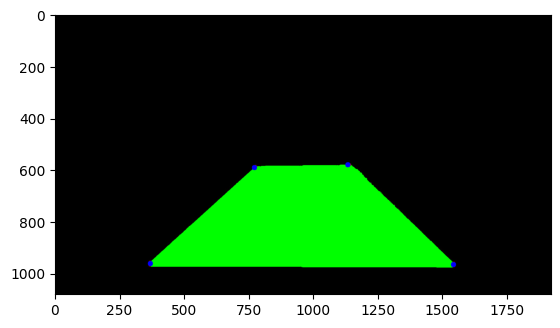

In [61]:
for point in approx:
    cv2.circle(img, tuple(point[0]), 10, (0, 0, 255), -1)

# Show result
plt.imshow(img)
cv2.imwrite('/mnt/DATA/sda1/Suraj/Kunal/Bird Eye View/Bird_Eye_view_test/Green_patch.jpg',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [56]:
# Sort points by y-coordinate (top to bottom)
sorted_by_y = sorted(approx, key=lambda p: p[0][1])

# Top two points
top_points = sorted(sorted_by_y[:2], key=lambda p: p[0][0])  # left to right
# Bottom two points
bottom_points = sorted(sorted_by_y[2:], key=lambda p: p[0][0])  # left to right

# Final order: top-left, top-right, bottom-left, bottom-right
ordered_points = [top_points[0], top_points[1], bottom_points[0], bottom_points[1]]
print(ordered_points)

[array([[770, 592]], dtype=int32), array([[1131,  581]], dtype=int32), array([[368, 962]], dtype=int32), array([[1539,  966]], dtype=int32)]


In [57]:
pts = approx.reshape(-1, 2)
def sort_corners(pts):
    # Sort by y (top to bottom)
    pts = sorted(pts, key=lambda x: x[1])
    top = sorted(pts[:2], key=lambda x: x[0])
    bottom = sorted(pts[2:], key=lambda x: x[0])
    return np.float32([top[0], top[1], bottom[1], bottom[0]])
sorted_pts = sort_corners(pts)
print(sorted_pts)

[[ 770.  592.]
 [1131.  581.]
 [1539.  966.]
 [ 368.  962.]]


In [58]:
h, w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w,h), 1, (w,h))
undistorted = cv2.undistort(img, camera_matrix, dist_coeffs, None, newcameramtx)
print(newcameramtx)
print(roi)

[[2.57026386e+03 0.00000000e+00 8.82617421e+02]
 [0.00000000e+00 2.57362796e+03 7.20883853e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
(53, 80, 1794, 984)


In [59]:
width, height = 600,800
dst_points = np.float32([
    [0, 0],
    [width, 0],
    [width, height],
    [0, height]
])

M = cv2.getPerspectiveTransform(sorted_pts, dst_points)
bird_eye = cv2.warpPerspective(undistorted, M, (width, height))
cv2.imwrite("/mnt/DATA/sda1/Suraj/Kunal/Bird Eye View/Bird_Eye_view_test/bird_eye.jpg",bird_eye)


True

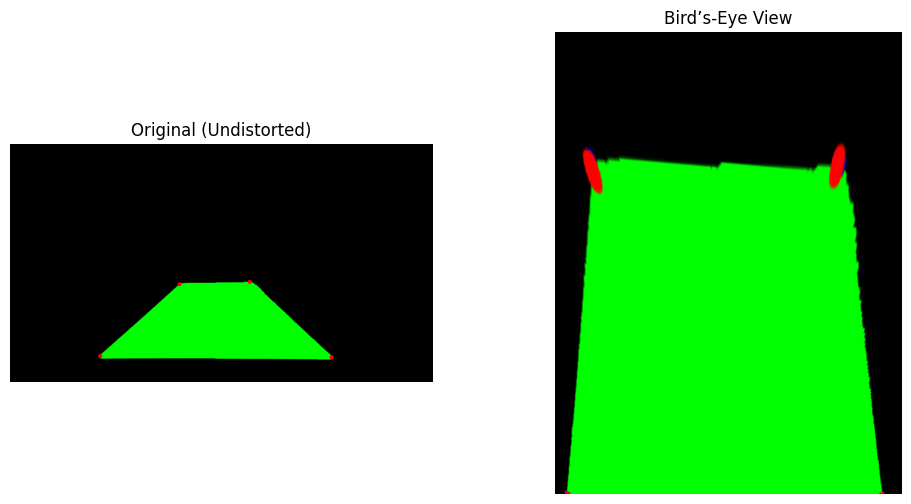

In [60]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Original (Undistorted)")
plt.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Bird’s-Eye View")
plt.imshow(cv2.cvtColor(bird_eye, cv2.COLOR_BGR2RGB))
cv2.imwrite("/mnt/DATA/sda1/Suraj/Kunal/Bird Eye View/Bird_Eye_view_test/bird_eye_auto.jpg",bird_eye)
plt.axis("off")

plt.show()

In [29]:
plt.add_subplot(2,2,1)
plt.imshow()

AttributeError: module 'matplotlib.pyplot' has no attribute 'add_subplot'

In [62]:
bird_eye_path = "/mnt/DATA/sda1/Suraj/Kunal/Bird Eye View/Bird_Eye_view_test/bird_eye_auto.jpg"  # change if needed
#out_path = Path("/mnt/DATA/sda1/Suraj/Kunal/Bird Eye View/reddot_distance_annotated.png")
img = cv2.imread(bird_eye_path)
if img is None:
    raise FileNotFoundError(f"Could not open: {bird_eye_path}")

In [22]:
known_distance_m=1.676

In [23]:
n_samples = 200
y_frac_start = 0.05
y_frac_end = 0.95

In [31]:
h, w = img.shape[:2]

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
lower1 = np.array([0, 100, 50])
upper1 = np.array([10, 255, 255])
lower2 = np.array([170, 100, 50])
upper2 = np.array([180, 255, 255])
mask1 = cv2.inRange(hsv, lower1, upper1)
mask2 = cv2.inRange(hsv, lower2, upper2)
mask_red = cv2.bitwise_or(mask1, mask2)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
mask_red = cv2.morphologyEx(mask_red, cv2.MORPH_OPEN, kernel, iterations=1)
mask_red = cv2.morphologyEx(mask_red, cv2.MORPH_CLOSE, kernel, iterations=1)

In [32]:
contours, _ = cv2.findContours(mask_red, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if len(contours) < 2:
    raise RuntimeError("Less than two red blobs found. Check marker visibility and HSV thresholds.")

contours = sorted(contours, key=cv2.contourArea, reverse=True)
c1, c2 = contours[0], contours[1]

def centroid(cnt):
    M = cv2.moments(cnt)
    if M["m00"] == 0:
        return None
    return np.array([M["m10"]/M["m00"], M["m01"]/M["m00"]], dtype=float)

p1 = centroid(c1)
p2 = centroid(c2)
if p1 is None or p2 is None:
    raise RuntimeError("Could not compute centroid for a red marker.")

In [33]:
dist_px = float(np.linalg.norm(p2 - p1))
#meters_per_pixel = known_distance_m / dist_px
print(dist_px)

424.3379173409148


In [34]:
distance=dist_px*4.0026
print(distance)

1698.4549479487457


In [42]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, mask_roi = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
mask_roi = cv2.morphologyEx(mask_roi, cv2.MORPH_CLOSE, kernel2, iterations=2)
mask_roi = cv2.morphologyEx(mask_roi, cv2.MORPH_OPEN, kernel2, iterations=1)

ys = np.linspace(int(h * y_frac_start), int(h * y_frac_end), n_samples).astype(int)
left_xs, right_xs, valid_rows = [], [], []
for y in ys:
    row = mask_roi[y]
    xs = np.where(row > 0)[0]
    if xs.size >= 2:
        left_xs.append(xs.min())
        right_xs.append(xs.max())
        valid_rows.append(y)

left_xs = np.array(left_xs)
right_xs = np.array(right_xs)
if left_xs.size == 0:
    raise RuntimeError("No valid rows found to measure width. Check bird-eye mask.")

dists_px_rows = (right_xs - left_xs).astype(float)
median_px = float(np.median(dists_px_rows))
mean_px = float(np.mean(dists_px_rows))
std_px = float(np.std(dists_px_rows))

In [47]:
meters_per_pixel=0.00426
median_m = median_px * meters_per_pixel
mean_m   = mean_px   * meters_per_pixel
std_m    = std_px    * meters_per_pixel

In [48]:
annot = img.copy()
for xL, xR, y in zip(left_xs, right_xs, valid_rows):
    cv2.circle(annot, (int(xL), int(y)), 2, (255,0,0), -1)
    cv2.circle(annot, (int(xR), int(y)), 2, (0,0,255), -1)
mid_idx = len(valid_rows)//2
if valid_rows:
    mid_y = valid_rows[mid_idx]
    mid_left = int(left_xs[mid_idx])
    mid_right = int(right_xs[mid_idx])
    cv2.line(annot, (mid_left, mid_y), (mid_right, mid_y), (0,255,0), 2)
    cv2.putText(annot, f"Median: {median_px:.1f}px = {median_m:.3f}m", (10,90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

In [49]:
print("Red marker pixel distance: {:.2f} px".format(dist_px))
print("Scale (m/px): {:.8f}".format(meters_per_pixel))
print("\nTrack width statistics (across sampled rows):")
print(f"  Median: {median_px:.2f} px  -> {median_m:.4f} m")
print(f"  Mean  : {mean_px:.2f} px  -> {mean_m:.4f} m")
print(f"  Std   : {std_px:.2f} px  -> {std_m:.4f} m")
print(f"  Samples: {len(dists_px_rows)}")

Red marker pixel distance: 423.84 px
Scale (m/px): 0.00426000

Track width statistics (across sampled rows):
  Median: 478.00 px  -> 2.0363 m
  Mean  : 473.36 px  -> 2.0165 m
  Std   : 59.13 px  -> 0.2519 m
  Samples: 157


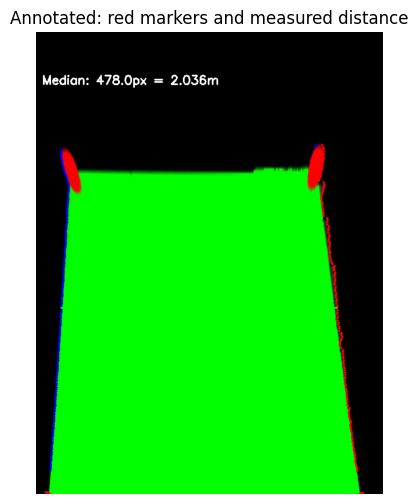

In [50]:
plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(annot, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Annotated: red markers and measured distance")
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
img_path = "/mnt/DATA/sda1/Suraj/Kunal/Bird Eye View/Bird_Eye_view_test/bird_eye_auto.jpg"
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Could not open: {img_path}")

# Convert to HSV
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define HSV range for blue
lower_blue = np.array([100, 100, 50])
upper_blue = np.array([130, 255, 255])
mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

# Morphological cleanup
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask_blue = cv2.morphologyEx(mask_blue, cv2.MORPH_OPEN, kernel, iterations=1)
mask_blue = cv2.morphologyEx(mask_blue, cv2.MORPH_CLOSE, kernel, iterations=1)

# Find contours
contours, _ = cv2.findContours(mask_blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = [c for c in contours if cv2.contourArea(c) > 5]

print(f"Blue blobs detected: {len(contours)}")
if len(contours) < 2:
    raise RuntimeError("Less than two blue blobs found. Check marker visibility and HSV thresholds.")

# Sort and pick top two
contours = sorted(contours, key=cv2.contourArea, reverse=True)
c1, c2 = contours[:2]

# Centroid function
def centroid(cnt):
    M = cv2.moments(cnt)
    if M["m00"] == 0:
        return None
    return np.array([M["m10"]/M["m00"], M["m01"]/M["m00"]], dtype=float)

p1 = centroid(c1)
p2 = centroid(c2)
if p1 is None or p2 is None:
    raise RuntimeError("Could not compute centroid for a blue marker.")

# Draw centroids
debug_img = img.copy()
for pt in [p1, p2]:
    cv2.circle(debug_img, tuple(pt.astype(int)), 6, (0, 255, 255), -1)  # Yellow dot

# Measure distance
dist_px = float(np.linalg.norm(p2 - p1))
scale_mm_per_px = 4.026
actual_distance_mm = dist_px * scale_mm_per_px

# Annotate image
midpoint = ((p1 + p2) / 2).astype(int)
cv2.putText(debug_img, f"{actual_distance_mm:.2f} mm", tuple(midpoint),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)

# Save and display result
cv2.imwrite("/mnt/DATA/sda1/Suraj/Kunal/Bird Eye View/Bird_Eye_view_test/blue_dot_distance_debug.jpg", debug_img)

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
plt.title("Blue Dot Distance Measurement")
plt.axis("off")
plt.show()

print(f"Pixel Distance: {dist_px:.2f}")
print(f"Actual Distance: {actual_distance_mm:.2f} mm")